# PixCell Inference Notebook

This notebook provides an interactive interface to the PixCell model with all the optimizations from [optimized_pixcell_inference.py](cci:7://file:///Users/nicorosen/code_projects/python/pixcell-vae-histo/notebooks/optimized_pixcell_inference.py:0:0-0:0).

## Features
- Memory-efficient inference
- Support for both GPU and MPS (Apple Silicon)
- Command-line like interface in notebook cells
- Visualization of results

In [2]:
# Standard imports
import os
import sys
import random
from pathlib import Path
from datetime import datetime
import warnings
import argparse

# Third-party imports
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from diffusers import AutoencoderKL, DiffusionPipeline
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from huggingface_hub import login, hf_hub_download
import einops

# Suppress warnings
warnings.filterwarnings('ignore')

# Optional: lower MPS high watermark to release memory more aggressively
os.environ.setdefault("PYTORCH_MPS_HIGH_WATERMARK_RATIO", "0.0")

'0.0'

## Configuration

Here we set up the model configuration and device settings.

In [3]:
# Configuration
SEED = 34
MODEL_CONFIG = {
    'vae_path': "stabilityai/stable-diffusion-3.5-large",
    'pipeline_path': "StonyBrook-CVLab/PixCell-1024",
    'pipeline_name': "StonyBrook-CVLab/PixCell-pipeline",
    'uni_model_name': "hf-hub:MahmoodLab/UNI2-h",
    'uni_model_config': {
        'img_size': 224,
        'patch_size': 14,
        'depth': 24,
        'num_heads': 24,
        'init_values': 1e-5,
        'embed_dim': 1536,
        'mlp_ratio': 2.66667 * 2,
        'num_classes': 0,
        'no_embed_class': True,
        'mlp_layer': timm.layers.SwiGLUPacked,
        'act_layer': torch.nn.SiLU,
        'reg_tokens': 8,
        'dynamic_img_size': True
    },
    'generation': {
        'num_inference_steps': 22,
        'guidance_scale': 1.5,
        'num_samples': 2
    }
}

# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(SEED)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
DTYPE = torch.float16 if device.type == 'cuda' else torch.float32

# Adjust model for non-CUDA devices
if device.type != 'cuda' and MODEL_CONFIG.get('pipeline_path', '').endswith('PixCell-1024'):
    print("MPS/CPU detected: switching to PixCell-256 for faster inference.")
    MODEL_CONFIG['pipeline_path'] = "StonyBrook-CVLab/PixCell-256"
    MODEL_CONFIG['generation']['num_inference_steps'] = min(MODEL_CONFIG['generation']['num_inference_steps'], 18)
    MODEL_CONFIG['generation']['guidance_scale'] = 1.0

# Output directory
OUT_DIR = Path("generated_samples")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Using device: {device}")
print(f"Using dtype: {DTYPE}")

MPS/CPU detected: switching to PixCell-256 for faster inference.
Using device: mps
Using dtype: torch.float32


## Model Loading and Utilities

This section contains the model loading code and utility functions.

In [4]:
class ModelLoadingError(Exception):
    """Custom exception for model loading errors."""
    pass

def clear_memory():
    """Clear GPU/CPU cache if needed."""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    elif torch.backends.mps.is_available():
        torch.mps.empty_cache()

def load_models():
    """Load all required models and return them in a dictionary."""
    # Accept either HUGGING_FACE_HUB_TOKEN or HF_TOKEN from .env / environment
    token = os.getenv('HUGGING_FACE_HUB_TOKEN') or os.getenv('HF_TOKEN')
    if not token:
        raise ModelLoadingError(
            "Hugging Face token not found. Set HUGGING_FACE_HUB_TOKEN (preferred) or HF_TOKEN in your .env."
        )
    
    try:
        # Login to Hugging Face
        login(token=token)
        
        # Load VAE
        print("Loading VAE...")
        vae = AutoencoderKL.from_pretrained(
            MODEL_CONFIG['vae_path'],
            subfolder="vae" if "stable-diffusion-3.5-large" in MODEL_CONFIG['vae_path'] else None,
            torch_dtype=DTYPE
        )
        
        # Load PixCell pipeline
        print("Loading PixCell pipeline...")
        pipeline = DiffusionPipeline.from_pretrained(
            MODEL_CONFIG['pipeline_path'],
            vae=vae,
            custom_pipeline=MODEL_CONFIG['pipeline_name'],
            trust_remote_code=True,
            torch_dtype=DTYPE
        )
        pipeline.to(device)
        
        # Load UNI model
        print("Loading UNI model...")
        uni_model = timm.create_model(
            MODEL_CONFIG['uni_model_name'],
            pretrained=True,
            **MODEL_CONFIG['uni_model_config']
        )
        uni_model.eval()
        uni_model.to(device)
        
        # Get transform for UNI model
        transform = create_transform(**resolve_data_config(uni_model.pretrained_cfg, model=uni_model))
        
        # Generate unconditional embedding
        print("Generating unconditional embedding...")
        uncond = pipeline.get_unconditional_embedding(1).to(device)
        
        return {
            'pipeline': pipeline,
            'uni_model': uni_model,
            'transform': transform,
            'uncond': uncond
        }
        
    except Exception as e:
        raise ModelLoadingError(f"Failed to load models: {e}") from e

## Image Processing and Generation

This section contains functions for processing images and generating samples.

In [10]:
def _download_and_process_image(transform):
    """Download and process the example image for conditioning."""
    path = hf_hub_download(
        repo_id=MODEL_CONFIG['pipeline_path'],
        filename="test_image.png"
    )
    image = Image.open(path).convert("RGB")
    return transform(image).unsqueeze(0)

def _extract_uni_embeddings(uni_model, transform, image):
    """Extract UNI embeddings from the processed image."""
    with torch.no_grad():
        uni_emb = uni_model(image.to(device))
    return uni_emb.unsqueeze(0)  # Add batch dimension

def generate_samples(pipeline, uni_model, transform, uncond, num_samples=None):
    """Generate samples using the PixCell pipeline with UNI model."""
    num_samples = num_samples or MODEL_CONFIG['generation']['num_samples']
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    samples = []
    
    try:
        # Download and process example image
        print("Downloading example image for conditioning...")
        image_input = _download_and_process_image(transform)
        
        # Extract UNI embeddings
        print("Extracting UNI embeddings...")
        uni_emb = _extract_uni_embeddings(uni_model, transform, image_input)
        print(f"Extracted UNI embeddings with shape: {uni_emb.shape}")
        
        # Generate samples
        for i in range(num_samples):
            print(f"\nGenerating sample {i+1}/{num_samples}")
            generator = torch.Generator(device).manual_seed(SEED + i)
            
            with torch.amp.autocast('cuda' if device.type == 'cuda' else 'cpu'):
                sample = pipeline(
                    uni_embeds=uni_emb,
                    negative_uni_embeds=uncond,
                    guidance_scale=MODEL_CONFIG['generation']['guidance_scale'],
                    generator=generator,
                    num_inference_steps=MODEL_CONFIG['generation']['num_inference_steps']
                )
            
            # Save the generated image
            img_path = OUT_DIR / f'sample_{timestamp}_{i:02d}.png'
            sample.images[0].save(img_path)
            print(f"Saved to {img_path}")
            samples.append(sample.images[0])
            
            clear_memory()
                
    except Exception as e:
        print(f"Error during sample generation: {e}")
        import traceback
        traceback.print_exc()
    
    return samples

def display_samples(samples):
    """Display generated samples in a grid."""
    if not samples:
        print("No samples to display.")
        return
    
    n = len(samples)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5))
    
    if n == 1:
        axes = [axes]
    
    for i, (img, ax) in enumerate(zip(samples, axes)):
        ax.imshow(img)
        ax.set_title(f"Sample {i+1}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

## Main Execution

Run the model and generate samples.

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Initializing models...
Loading VAE...
Loading PixCell pipeline...


Keyword arguments {'trust_remote_code': True} are not expected by PixCellPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00, 25.96it/s]
Expected types for transformer: (<class 'diffusers_modules.local.StonyBrook-CVLab--PixCell-pipeline.2730c93b7b1c71aa99f09c6dc4623d80caaa9bec.pixcell_transformer_2d.PixCellTransformer2DModel'>,), got <class 'diffusers_modules.local.pixcell_transformer_2d.PixCellTransformer2DModel'>.


Loading UNI model...
Generating unconditional embedding...

Generating samples...
Extracting UNI embeddings...
Extracted UNI embeddings with shape: torch.Size([1, 1, 1536])

Generating sample 1/2


100%|██████████| 18/18 [00:01<00:00,  9.27it/s]


Saved to generated_samples/sample_20250809_123231_00.png

Generating sample 2/2


100%|██████████| 18/18 [00:01<00:00, 10.98it/s]


Saved to generated_samples/sample_20250809_123231_01.png

Successfully generated 2 samples


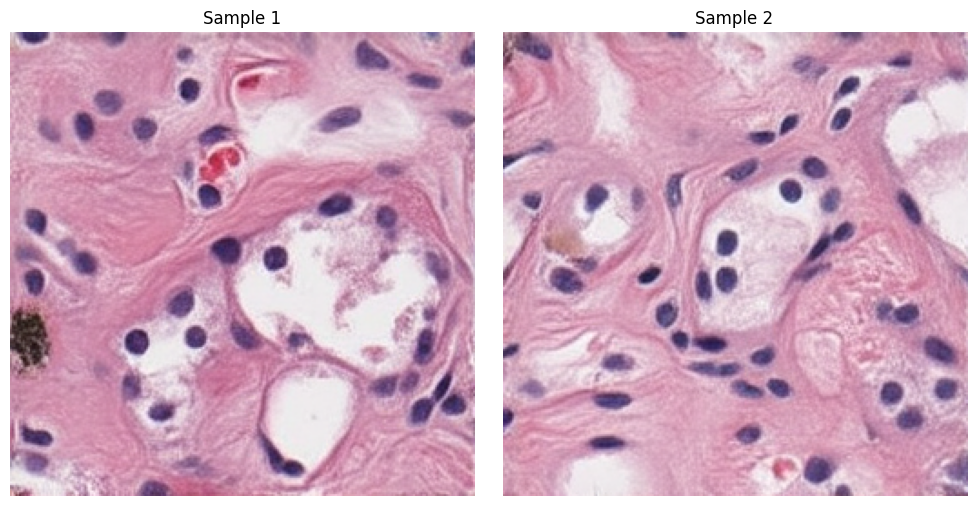

In [11]:
def main():
    """Run the PixCell inference pipeline."""
    try:
        # Load models
        print("Initializing models...")
        models = load_models()
        
        # Generate samples
        print("\nGenerating samples...")
        samples = generate_samples(
            pipeline=models['pipeline'],
            uni_model=models['uni_model'],
            transform=models['transform'],
            uncond=models['uncond']
        )
        
        # Display results
        if samples:
            print(f"\nSuccessfully generated {len(samples)} samples")
            display_samples(samples)
        else:
            print("\nNo samples were generated.")
            
    except ModelLoadingError as e:
        print(f"\nError: {e}")
        print("Please check your Hugging Face token and internet connection.")
    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")
        import traceback
        traceback.print_exc()
    finally:
        clear_memory()

# Run the main function
if __name__ == "__main__":
    main()

## Interactive Usage

You can also use the functions interactively:

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Loading VAE...
Loading PixCell pipeline...


Keyword arguments {'trust_remote_code': True} are not expected by PixCellPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00, 12.87it/s]
Expected types for transformer: (<class 'diffusers_modules.local.StonyBrook-CVLab--PixCell-pipeline.2730c93b7b1c71aa99f09c6dc4623d80caaa9bec.pixcell_transformer_2d.PixCellTransformer2DModel'>,), got <class 'diffusers_modules.local.pixcell_transformer_2d.PixCellTransformer2DModel'>.


Loading UNI model...
Generating unconditional embedding...
Extracting UNI embeddings...
Extracted UNI embeddings with shape: torch.Size([1, 1, 1536])

Generating sample 1/4


100%|██████████| 25/25 [00:04<00:00,  5.20it/s]


Saved to generated_samples/sample_20250809_124329_00.png

Generating sample 2/4


100%|██████████| 25/25 [00:04<00:00,  5.56it/s]


Saved to generated_samples/sample_20250809_124329_01.png

Generating sample 3/4


100%|██████████| 25/25 [00:04<00:00,  5.59it/s]


Saved to generated_samples/sample_20250809_124329_02.png

Generating sample 4/4


100%|██████████| 25/25 [00:04<00:00,  5.57it/s]


Saved to generated_samples/sample_20250809_124329_03.png


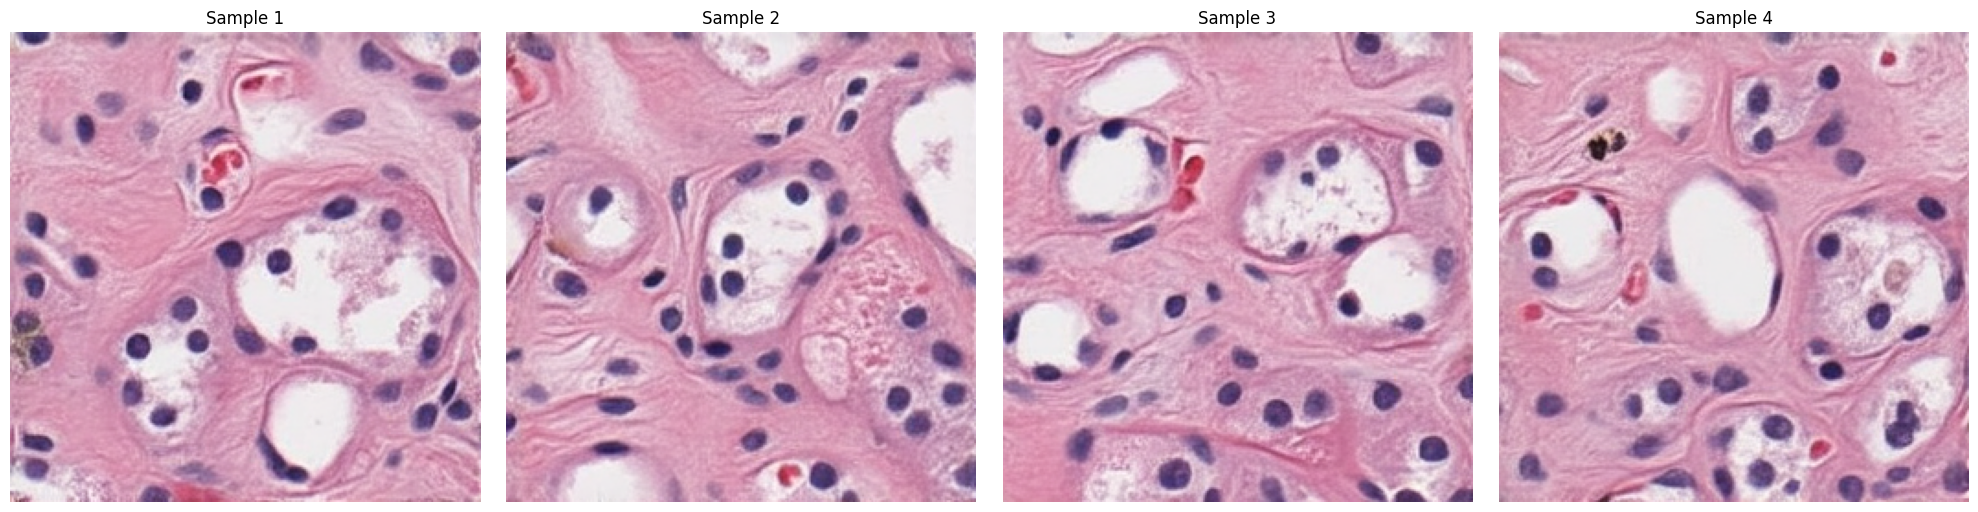

In [15]:
# Example: Generate a single sample with custom settings
def generate_custom_sample(num_samples=2, seed=42, num_inference_steps=15, guidance_scale=1.5):
    try:
        # Set random seed for reproducibility
        torch.manual_seed(seed)
        
        # Load models (if not already loaded)
        if 'models' not in locals():
            models = load_models()
        
        # Update config with custom settings
        custom_config = MODEL_CONFIG.copy()
        custom_config['generation']['num_inference_steps'] = num_inference_steps
        custom_config['generation']['guidance_scale'] = guidance_scale
        
        # Generate samples
        samples = generate_samples(
            pipeline=models['pipeline'],
            uni_model=models['uni_model'],
            transform=models['transform'],
            uncond=models['uncond'],
            num_samples=num_samples
        )
        
        if samples:
            display_samples(samples)
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

# Now you can call it with custom parameters
generate_custom_sample(
    num_samples=4,       # Generate 4 images
    seed=123,            # Set specific random seed
    num_inference_steps=25,  # More steps for better quality
    guidance_scale=2.0   # Stronger guidance
)